In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

# %matplotlib inline

### Agent class

In [2]:
class Agent():
    def __init__(self, x=0.0, y=0.0, vx=0.0, vy=0.0, v_min=0.0, v_max=10.0, psi=0.0):
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.v_min = v_min
        self.v_max = v_max
        self.psi = psi
        
    def update(self, ax=0.0, ay=0.0, vpsi=0.0, dt=0.1):
        # Increment velocity
        self.vx += ax * dt
        self.vy += ay * dt
        
        # Limit velocity
        v_norm = np.sqrt(self.vx**2 + self.vy**2)
        if v_norm < self.v_min:
            self.vx = self.vx * self.v_min / v_norm
            self.vy = self.vy * self.v_min / v_norm
        elif v_norm > self.v_max:
            self.vx = self.vx * self.v_max / v_norm
            self.vy = self.vy * self.v_max / v_norm
                
        # Increment position
        self.x += self.vx * dt
        self.y += self.vy * dt
        
        # Increment heading
        self.psi += vpsi * dt   

### Plot single agent

In [3]:
def agent_marker(angle):
    a = np.array([[-1.0,-1.0],
                  [-0.5, 0.0],
                  [-1.0, 1.0],
                  [ 1.0, 0.0]])
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle), np.cos(angle)]])
    return R.dot(a.T).T  

def plot_agent(ax, agent, **args):
    return ax.plot([agent.x], [agent.y], marker=agent_marker(agent.psi), **args)[0]

### Example with N agents

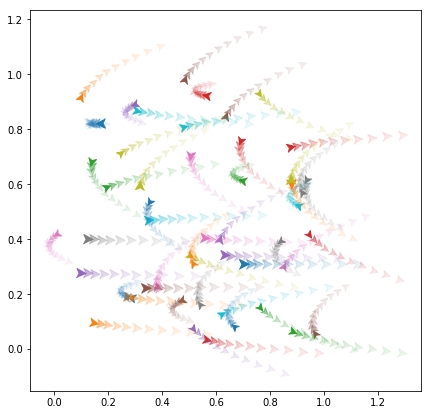

In [4]:
# Init N agents
n_agents = 50
agents = [Agent(x=_x, y=_y, vx=0.1 * np.cos(_psi), vy=0.1 * np.sin(_psi), psi=_psi)
          for (_x, _y, _psi) in zip(np.random.rand(n_agents), 
                                    np.random.rand(n_agents),
                                    2.0*np.pi*np.random.rand(n_agents))]

# Plot init state
fig, axis = plt.subplots(figsize=[7, 7])
for agent in agents:
    plot_agent(axis, agent, markersize=10, alpha=1.0)
        
# Update agents state
for i in range(10):
    for agent in agents:
        # update with fixed accel
        agent.update(dt=0.2, ax=0.1)
        
        # coordinated turn
        agent.psi = np.arctan2(agent.vy, agent.vx)
        
        # plot state
        plot_agent(axis, agent, markersize=10, alpha=1.0 / (2 + i))

plt.show(fig)

### Reynolds class

In [5]:
class Reynolds:
    def __init__(self, 
                 k_cohesion=1.0, k_separation=1.0, k_alignment=1.0,
                 dist_max=0.5, n_max=5):
        self.k_cohesion = k_cohesion 
        self.k_separation = k_separation 
        self.k_alignment = k_alignment
        self.dist_max = dist_max
        self.n_max = n_max
        
    def compute_one(self, index, agents):
        a = agents[index]
        others = np.hstack([np.array(agents)[:index],
                            np.array(agents)[index+1:]])
                
        # Compute distance to other agents
        distances = np.array([np.sqrt((a.x - b.x)**2 + (a.y - b.y)**2)
                             for b in others])
                
        # Remove agents that are too far
        sel_index = distances < self.dist_max
        others = others[sel_index]
        distances = distances[sel_index]
        
        # Keep max n_max agents
        sel_index = distances.argsort()[:self.n_max]
        others = others[sel_index]
        distances = distances[sel_index]
        
        n_neighbors = len(distances)
        if n_neighbors > 0:
            # Compute cohesion accel
            pos_a = np.array([a.x, a.y])
            pos_others = np.array([[b.x, b.y]
                                   for b in others])
            cohesion = self.k_cohesion * (pos_others - pos_a).mean(axis=0)

            # Compute separation accel
            pos_rel = pos_others - pos_a
            pos_rel_u = pos_rel / np.linalg.norm(pos_rel, axis=1)[:,np.newaxis]
            separation = - self.k_separation * (pos_rel_u / distances[:, np.newaxis]).sum(axis=0)

            # Compute alignment vpsi
            vel_a = np.array([a.vx, a.vy])
            vel_others = np.array([[b.vx, b.vy]
                                   for b in others])
            alignment = self.k_alignment * (vel_others - vel_a).mean(axis=0)
        else:
            cohesion = np.array([0.0, 0.0])
            separation = np.array([0.0, 0.0])
            alignment = np.array([0.0, 0.0])
            
        return cohesion, separation, alignment
    
    def update_one(self, index, agents):
        cohesion, separation, alignment = self.compute_one(index, agents)
        accel = cohesion + separation + alignment 
        return accel
    
    def update(self, agents):
        return np.array([self.update_one(i, agents)
                        for i in range(len(agents))])

In [6]:
reynolds = Reynolds(n_max=5)
reynolds.update_one(3, agents)
reynolds.update(agents)

array([[ 28.56425972,  -6.09126126],
       [ 19.78410183,   1.62908972],
       [-10.96197396, -11.90453414],
       [ 17.04453447,   3.72925804],
       [ -3.9619261 ,  -4.29936202],
       [ -0.9746786 ,  13.80203716],
       [-26.15915582,   8.44310313],
       [ -6.13155785,  17.30105325],
       [ 10.86011319,  28.97706649],
       [ -8.28884829,   2.22765742],
       [-29.36750357,  -9.75660549],
       [  0.50651532, -21.62033658],
       [ -8.5986459 ,  11.3617862 ],
       [ -2.66605503,  -8.25803929],
       [ -5.03429632, -11.71065532],
       [ 28.82623386,  13.90537339],
       [-12.358449  ,  -1.12397287],
       [-11.14227355, -17.16488176],
       [ -0.91718651, -24.25926706],
       [ 25.30320563,  10.12832614],
       [ -8.23303981,  -6.40342639],
       [ -4.14408251,  12.57405985],
       [ -0.687689  ,   5.74008719],
       [ -7.88488599,  -2.76859644],
       [  3.35607689,  -1.37588826],
       [  3.44794649,  10.32202384],
       [  0.60508892,  27.77089618],
 

### Example with N agents

In [38]:
# Init N agents
n_agents = 50
agents = [Agent(x=_x, y=_y, vx=0.1 * np.cos(_psi), vy=0.1 * np.sin(_psi), 
                v_min=0.8, v_max=1.2, 
                psi=_psi)
          for (_x, _y, _psi) in zip(5.0*(np.random.rand(n_agents) - 0.5)*2.0, 
                                    5.0*(np.random.rand(n_agents) - 0.5)*2.0,
                                    2.0*np.pi*np.random.rand(n_agents))]

# Init Reynolds
reynolds = Reynolds(dist_max=1, n_max=50,
                    k_separation=0.2,
                    k_cohesion=1.0,
                    k_alignment=1.0)

# Waypoint for migration rule
pos_wpt = np.array([0, 0])
rad_wpt = 5.0
vel_wpt = 1.0

# Obstacles for avoidance rule
add_obstacles = True
if add_obstacles:
    pos_obs = [r * np.array([np.cos(theta), np.sin(theta)])
               for r, theta in zip([3.0,             7.0,           5.0],
                                   [np.pi / 4, np.pi / 4, 7 * np.pi / 4])]
    rad_obs = [0.75 for _ in range(len(pos_obs))]
else:
    pos_obs = []
    rad_obs = []

def migration(agent, center, radius, velocity):
    # Circle waypoint around which agents will rotate at constant velocity
    vel_agent = 1.0
    pos_a = np.array([agent.x, agent.y])
    pos_tan = radius * (pos_a - center) / np.linalg.norm(pos_a - center)
    pos_ang = np.arctan2(pos_tan[1], pos_tan[0])
    pos_ang_pre = pos_ang + (1.0 * vel_agent) / radius
    pos_mig = center + radius * np.array([np.cos(pos_ang_pre), np.sin(pos_ang_pre)])     
    pos_rel = pos_mig - pos_a
    vel_des = 1.0 * pos_rel
    vel_a = np.array([agent.vx, agent.vy])
    centrifugal_acceleration = (velocity**2 / radius) * pos_tan / radius
    migration = 1.0 * (vel_des - vel_a) - centrifugal_acceleration
    return migration

def avoidance(agent, center, radius):
    # Repulsive obstacle to avoid
    pos_a = np.array([agent.x, agent.y])
    pos_rel = center - pos_a
    dist = np.linalg.norm(pos_rel)
    vel_des = - (pos_rel / dist) * 1.0 / max(0.01, dist - radius)
    vel_a = np.array([agent.vx, agent.vy])
    avoidance = 1.0 * (vel_des - vel_a)
    return avoidance

# Timing
dt = 0.1
n_steps = 1000

# Prepare trajectories
trajectories = np.zeros([n_agents, n_steps, 3])

# Update agents state
for k in range(n_steps):       
    for i, agent in enumerate(agents):
        # Reynolds rules
        accel = reynolds.update_one(i, agents)

        # Add migration rule as fixed-speed velocity command towards the moving waypoint
        accel += migration(agent, pos_wpt, rad_wpt, vel_wpt)

        # Add repulsion from a small circle on the path
        for pos, rad in zip(pos_obs, rad_obs):
            accel += avoidance(agent, pos, rad)
        
        # Update agent state
        agent.update(ax=accel[0], ay=accel[1], dt=dt)

        # coordinated turn
        agent.psi = np.arctan2(agent.vy, agent.vx)

        # save state
        trajectories[i][k] = [agent.x, agent.y, agent.psi]

print(trajectories.shape)
trajectories

(50, 1000, 3)


array([[[-2.33742955,  3.25208256,  3.04249343],
        [-2.41730499,  3.25654509,  3.08578213],
        [-2.49729193,  3.25799088,  3.12351929],
        ...,
        [ 1.26587438, -5.28003561,  0.16110643],
        [ 1.34468489, -5.26629138,  0.17265945],
        [ 1.42333317, -5.25164735,  0.18408839]],

       [[-1.39012285,  0.35896015,  3.06157078],
        [-1.48951304,  0.36511612,  3.07973427],
        [-1.5959207 ,  0.37061146,  3.08999423],
        ...,
        [ 0.51832639, -5.43105189,  0.02899953],
        [ 0.59825884, -5.42776502,  0.04109751],
        [ 0.67814589, -5.42351537,  0.05314565]],

       [[-1.27465631,  0.31961931, -2.98728423],
        [-1.35415378,  0.31066656, -3.02944832],
        [-1.43580184,  0.30270489, -3.0443879 ],
        ...,
        [-0.56169894, -5.37597975, -0.12190293],
        [-0.4821583 , -5.38454048, -0.10721439],
        [-0.40250016, -5.39192831, -0.09247966]],

       ...,

       [[ 0.73183495, -4.66132299, -0.75194813],
        [ 0

# Static plot

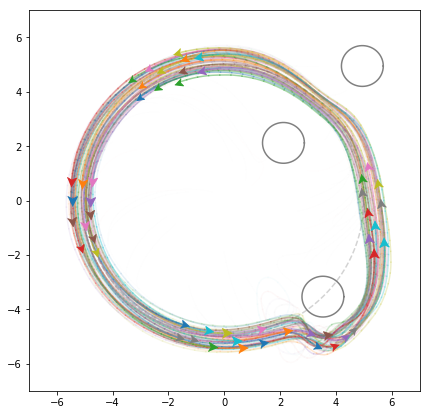

In [39]:
# Prepare figure
fig, axis = plt.subplots(figsize=[7, 7])
axis.set_xlim([-7, 7])
axis.set_ylim([-7, 7])
        
# plot circle
theta = np.linspace(0, 2.0*np.pi, 200)
axis.plot(pos_wpt[0] + rad_wpt * np.cos(theta),
          pos_wpt[1] + rad_wpt * np.sin(theta),
          linestyle='--',
          color='lightgrey')

# plot obstacle
for pos, rad in zip(pos_obs, rad_obs):
    axis.plot(pos[0] + rad * np.cos(theta),
              pos[1] + rad * np.sin(theta),
              linestyle='-',
              color='grey')

# plot trajectories
binsize = max(1, int(n_steps / 200.0))
for k in np.arange(0, n_steps, binsize):
    axis.plot(trajectories[:, k:k+binsize+1, 0].T, 
              trajectories[:, k:k+binsize+1, 1].T, 
              alpha=0.5*max(0.01, (1.0 * k / n_steps)**4),
              )

# plot agent
for i, agent in enumerate(agents):
    plot_agent(axis, agent, markersize=10, alpha=1.0)
    
plt.show()

# Animated plot

In [40]:
# Prepare figure
fig, axis = plt.subplots(figsize=[7, 7])
axis.set_xlim([-7, 7])
axis.set_ylim([-7, 7])
axis.set_xticks([])   
axis.set_yticks([])
fig.tight_layout()

# plot circle
theta = np.linspace(0, 2.0 * np.pi, 200)
axis.plot(pos_wpt[0] + rad_wpt * np.cos(theta),
          pos_wpt[1] + rad_wpt * np.sin(theta),
          linestyle='--',
          color='lightgrey')

# plot obstacle
for pos, rad in zip(pos_obs, rad_obs):
    axis.plot(pos[0] + rad * np.cos(theta),
              pos[1] + rad * np.sin(theta),
              linestyle='-',
              color='grey')

# plot trajectories to be animated
lines = axis.plot(trajectories[:, :1, 0].T, 
              trajectories[:, :1, 1].T, 
              alpha=0.25,
              )

# plot agents to be animated
agents = [Agent(x=_x, y=_y, psi=_psi)
          for (_x, _y, _psi) in trajectories[:, 0, :]]
markers = [plot_agent(axis, agent, markersize=10, alpha=1.0)
         for i, agent in enumerate(agents)]

# animate function
def animate(i):
    for k, (line, marker) in enumerate(zip(lines, markers)):
        # Update trails
        start_i = max(0, i-30)
        line.set_data(trajectories[k, start_i:i, 0].T, 
                      trajectories[k, start_i:i, 1].T)
        # Update markers
        marker.set_data(trajectories[k, i, 0].T, 
                        trajectories[k, i, 1].T)
        marker.set_marker(agent_marker(trajectories[k, i, 2]))
        
    return lines + markers

anim = animation.FuncAnimation(fig, animate, init_func=None,
                               frames=n_steps, interval=20, blit=True)

plt.close(fig)

anim

In [31]:
# anim.save('reynolds_50agents_10maxdist_50neighbors_3obstacles_300dpi.mp4', dpi=300)
# anim.save('reynolds_50agents_10maxdist_50neighbors_0obstacles_300dpi.mp4', dpi=300)
# anim.save('reynolds_50agents_5maxdist_50neighbors_0obstacles_300dpi.mp4', dpi=300)
# anim.save('reynolds_50agents_10maxdist_1neighbors_0obstacles_300dpi.mp4', dpi=300)